<a href="https://colab.research.google.com/github/pranshumalik14/ece421-labs-hw/blob/main/labs/lab3/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Unsupervised Learning and Probabilistic Models

In this lab, we will be creating a <>

## 1. $K$-means Clustering

We will use the $K$-means algorithm to discover protoype clusters that represent the given data. Contrary to alternating between assigning clusters and updating their means, here We investigate a different learning algorithm that directly minimizes the K-means clustering loss function.


### 1.1 Learning $K$-means

We use the loss function 

$$E_{\text{in}}(\boldsymbol{\mu}) = \frac{1}{N}\sum_{i=1}^N\min_{k = 1, \ldots, K} ||\mathbf{x}_n-\boldsymbol{\mu}_k||^2$$

In [233]:
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf2

In [234]:
def pairwise_sq_dist(X, Mu):
    # X:  N,D tensor
    # Mu: K,D tensor
    # return: N, K tensor with pairwise squared distances
    pair_dists = tf2.norm(tf2.expand_dims(X, axis=1) - Mu, axis=2)
    return tf2.math.square(pair_dists)

In [235]:
def min_sq_sum_loss(X, Mu):
    pair_sq_dists = pairwise_sq_dist(X, Mu)
    return tf2.reduce_mean(tf2.math.reduce_min(pair_sq_dists, axis=1))

In [236]:
def assign_clusters(X, Mu):
    # X:  N,D numpy ndarray
    # Mu: K,D numpy ndarray
    # return: N,1 array in {1,...,K}^N containing cluster assignment per sample
    pair_sq_dists = pairwise_sq_dist(tf2.convert_to_tensor(X), Mu)
    return tf2.argmin(pair_sq_dists, axis=1).numpy()

Now we will train a $K$-means model for $K = 3$ with ADAM on our data.

In [237]:
# load data
def loadDataGDrive(file='data2D.npy'):
    dataset = np.load('/content/drive/MyDrive/Colab Notebooks/'+file)
    num_pts, dim = np.shape(dataset)
    valid_batch  = int(num_pts/3.0)
    np.random.seed(45689)
    rnd_idx = np.arange(num_pts)
    np.random.shuffle(rnd_idx)
    val_data   = dataset[rnd_idx[:valid_batch]]
    train_data = dataset[rnd_idx[valid_batch:]]
    return dataset, train_data, val_data

X2D, X2D_train, X2D_valid = loadDataGDrive()
X100D, X100D_train, X100D_valid = loadDataGDrive(file='data100D.npy')

In [238]:
def plot2D_clusters_and_loss(X, Mu, loss_hist, title=""):
    # loss_hist = [train_loss, valid_loss]
    f, ax  = plt.subplots(1, 2, figsize=(8,4))
    
    assigned_clusters   = assign_clusters(X, Mu)
    cluster_percentages = [str(k+1)+" ("+"{:.2f}".format(100*np.mean(assigned_clusters==k))+"%)" 
                           for k in range(Mu.shape[0])]
    for k in range(Mu.shape[0]):
        idxs = assigned_clusters == k
        ax[0].scatter(X[idxs,0], X[idxs,1], s=1, label=cluster_percentages[k])
    ax0legend = ax[0].legend(title="Clusters")
    for handle in ax0legend.legendHandles:
        handle.set_sizes([10.0])
    ax[0].scatter(Mu[:,0], Mu[:,1], s=20, marker='x', c='k')
    
    labels = ["Training", "Validation"]
    for i in range(loss_hist.shape[1]):
        ax[1].plot(loss_hist[:, i], label=labels[i])
    
    # add axes lables and title
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    plt.suptitle(title+" K = "+str(Mu.shape[0])+" [Final/Validation Loss = "+
                 "{:.4f}".format(loss_hist.flatten()[-1])+"]", fontsize=14, y=1.03)
    return plt.tight_layout()

In [239]:
def k_means_tf2(X, K=1, epochs=500, validationset=None):
    train_loss_hist = np.empty((0,1), float)
    valid_loss_hist = np.empty((0,int(validationset is not None)), float)

    # convert datasets to tensors
    X_train = tf2.convert_to_tensor(X)
    if valid_loss_hist.shape != (0,0):
        X_valid = tf2.convert_to_tensor(validationset)

    # initialize Mu (N,K) by sampling from the standard normal distribution
    Mu = tf2.Variable(initial_value=tf2.random.normal([K, X_train.shape[1]], dtype=tf2.float64))

    # initialize ADAM optimizer
    optimizer = tf2.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.99, epsilon=1e-5)

    for _ in range(epochs):
        # gradient descent step
        with tf2.GradientTape() as tape:
            tape.watch(Mu)
            train_loss = min_sq_sum_loss(X_train, Mu)
        grad = tape.gradient(train_loss, Mu)
        optimizer.apply_gradients([(grad, Mu)])

        # update loss histories
        train_loss_hist = np.append(train_loss_hist, [[min_sq_sum_loss(X_train, Mu)]], axis=0)
        if  valid_loss_hist.shape != (0,0):
            valid_loss_hist = np.append(valid_loss_hist, [[min_sq_sum_loss(X_valid, Mu)]], axis=0)

    # compile loss history
    if valid_loss_hist.shape != (0,0):
        loss_hist = np.concatenate((train_loss_hist, valid_loss_hist), axis=1)
    else:
        loss_hist = train_loss_hist

    return Mu.numpy(), loss_hist

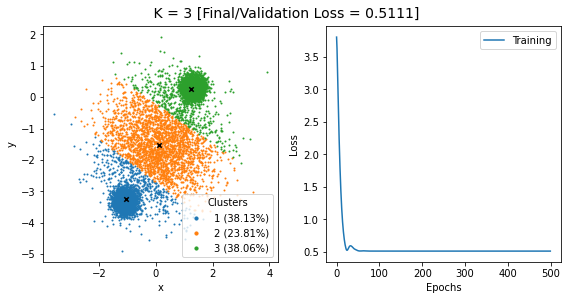

In [240]:
fulldata_Mu_k_3, fulldata_k_3_loss_history = k_means_tf2(X2D, K=3)
plot2D_clusters_and_loss(X2D, fulldata_Mu_k_3, fulldata_k_3_loss_history)

Now, we will try with validation.

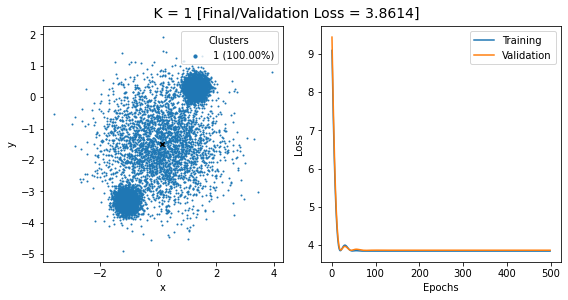

In [241]:
Mu_k_1, validation_k_1_loss_history = k_means_tf2(X2D_train, K=1, validationset=X2D_valid)
plot2D_clusters_and_loss(X2D, Mu_k_1, validation_k_1_loss_history)

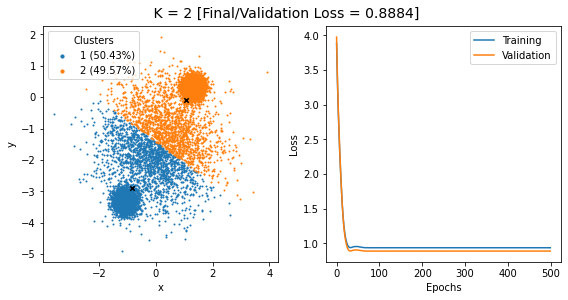

In [242]:
Mu_k_2, validation_k_2_loss_history = k_means_tf2(X2D_train, K=2, validationset=X2D_valid)
plot2D_clusters_and_loss(X2D, Mu_k_2, validation_k_2_loss_history)

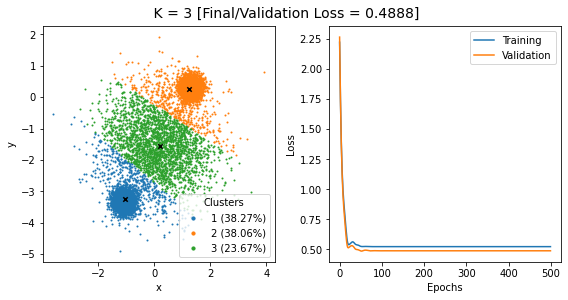

In [243]:
Mu_k_3, validation_k_3_loss_history = k_means_tf2(X2D_train, K=3, validationset=X2D_valid)
plot2D_clusters_and_loss(X2D, Mu_k_3, validation_k_3_loss_history)

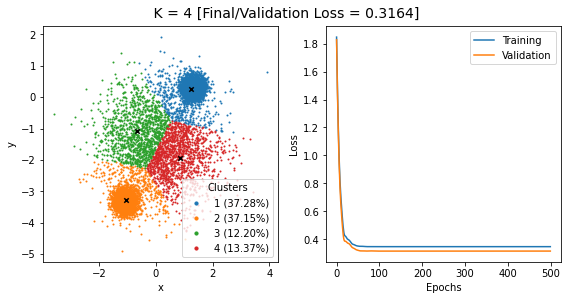

In [244]:
Mu_k_4, validation_k_4_loss_history = k_means_tf2(X2D_train, K=4, validationset=X2D_valid)
plot2D_clusters_and_loss(X2D, Mu_k_4, validation_k_4_loss_history)

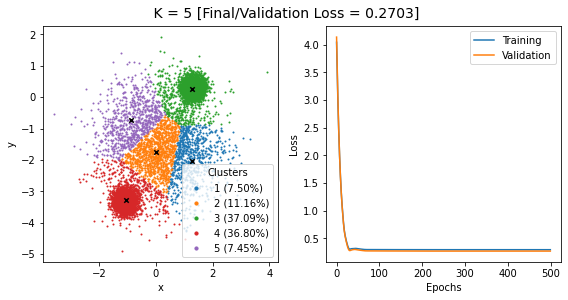

In [245]:
Mu_k_5, validation_k_5_loss_history = k_means_tf2(X2D_train, K=5, validationset=X2D_valid)
plot2D_clusters_and_loss(X2D, Mu_k_5, validation_k_5_loss_history)

## 2. Gaussian Mixture Models (GMMs)
